In [16]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230630_data'
dataname = data+'_1'
filename = 'myLearningData/'+data+'.csv'
SD = pd.read_csv(filename)
SD=SD.iloc[:,:5]
SensorData = SD

In [17]:
SD

,Time,Distance,Tension,Resistance,cycle
0,24.02,0.00,-3.1,8.46,Stretching
1,24.03,0.00,-3.1,8.46,Stretching
2,24.04,0.00,-3.0,8.46,Stretching
3,24.05,0.01,-3.1,8.39,Stretching
4,24.06,0.03,-2.8,8.39,Stretching
...,...,...,...,...,...
3878,71.95,0.00,-3.2,8.71,Relaxing
3879,71.97,0.00,-3.4,8.71,Relaxing
3880,71.98,0.00,-3.7,8.65,Relaxing
3881,71.99,0.00,-3.5,8.71,Relaxing


In [18]:
SD.describe()

,Time,Distance,Tension,Resistance
count,3883.000000,3883.000000,3883.000000,3883.000000
mean,48.008653,6.006531,22.930157,22.713667
std,13.858605,3.606321,14.749852,8.412671
min,24.020000,-0.010000,-4.900000,8.390000
25%,36.020000,2.860000,11.100000,15.040000
50%,48.010000,6.030000,22.900000,23.710000
75%,60.010000,9.140000,34.900000,30.430000
max,72.000000,12.010000,50.200000,35.470000


<Axes: >

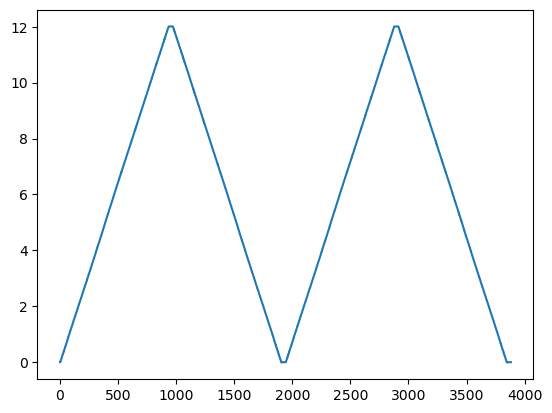

In [19]:
SDz=(SD.loc[:,'Distance'])
SDz.plot()

In [20]:
SD['Resistance'] = (SD['Resistance']-SD['Resistance'].mean())/(SD['Resistance'].max()-SD['Resistance'].min())*2
SD['Distance'] = (SD['Distance']-SD['Distance'].mean())/(SD['Distance'].max()-SD['Distance'].min())*2

In [21]:
X = SD.iloc[:,[0,3]]
X['index'] = X.index+1
X = X[['index','Time','Resistance']]
y = SD.iloc[:,[1]]
#y['index'] = y.index+1
#y = y[['index','Time','Distance']]

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_28760\1154935387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['index'] = X.index+1


In [22]:
X.sample(5)

,index,Time,Resistance
2497,2498,54.88,0.207262
698,699,32.64,0.487912
1742,1743,45.55,-0.664968
2757,2758,58.10,0.730158
1876,1877,47.21,-0.966297


In [23]:
y.sample(5)

,Distance
3123,0.552990
1045,0.845835
1724,-0.611736
2243,-0.362152
1528,-0.189107


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.20, random_state=42)


In [25]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  3075 ea 79 %    X_valid:  769 ea 19 %    X_test:  39 ea 1 %


In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid = X_valid.reshape((X_valid.shape[0], 1, X_valid.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [27]:
X_train.shape

(3075, 1, 3)

In [28]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_LSTM'+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230630_data_1_LSTM_SS.pkl']

In [29]:
from tensorflow import keras
model = keras.models.Sequential([
    keras.layers.LSTM(16, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.LSTM(16, return_sequences=True),
    keras.layers.LSTM(16),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho = 0.9))

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 16)             1280      
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             2112      
                                                                 
 lstm_5 (LSTM)               (None, 16)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 5,521
Trainable params: 5,521
Non-trainable params: 0
_________________________________________________________________


## Callback (best, early stopping, tensorboard)

In [31]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230630')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [32]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [33]:
dataname

'230630_data_1'

In [34]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 1
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
97/97 [==============================] - 7s 19ms/step - loss: 0.0687 - val_loss: 0.0072
Epoch 2/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0059 - val_loss: 0.0162
Epoch 3/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0047 - val_loss: 0.0211
Epoch 4/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 5/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0023 - val_loss: 0.0079
Epoch 6/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 7/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 8/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 9.1138e-04
Epoch 9/300
97/97 [==============================] - 1s 6ms/step - loss: 0.0016 - val_loss: 0.0079
Epoch 10/300
97/97 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 9.4386e-04


In [98]:
%load_ext tensorboard
%tensorboard --logdir=./mylog/230630 --port=1630

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 1630 (pid 22236), started 0:07:21 ago. (Use '!kill 22236' to kill it.)

In [35]:
model.save('H:/Jupyter_project/wearableActuator/myModel/'+dataname+'_LSTM'+'.h5')

In [36]:
model = tf.keras.models.load_model('myModel/'+dataname+'_LSTM'+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

25/25 [==============================] - 1s 2ms/step


In [37]:
X_valid

array([[[ 1.23422514,  1.23439576,  0.42769626]],

       [[-0.97306533, -0.97324874,  1.25884785]],

       [[ 1.09436433,  1.09442355,  0.93542405]],

       ...,

       [[ 0.81912543,  0.81883061,  1.45504243]],

       [[-1.16133949, -1.16108709,  0.59059721]],

       [[-0.92644506, -0.92610785,  1.40510199]]])

In [38]:
valid_predictions

array([[ 1.25711456e-01],
       [ 8.44283640e-01],
       [ 4.88055408e-01],
       [ 9.95274603e-01],
       [-4.39192981e-01],
       [-7.78492749e-01],
       [-5.84245361e-02],
       [-4.62885089e-02],
       [-6.73102438e-01],
       [ 3.07276636e-01],
       [-9.62082505e-01],
       [-3.72915596e-01],
       [ 1.01084352e+00],
       [-4.49619085e-01],
       [-4.14220214e-01],
       [ 6.66554809e-01],
       [ 7.32195258e-01],
       [ 8.04499805e-01],
       [ 9.99867439e-01],
       [ 6.51367128e-01],
       [ 6.00562915e-02],
       [-7.43758142e-01],
       [-1.11981742e-02],
       [-9.66049731e-01],
       [ 6.86324358e-01],
       [ 5.66224754e-01],
       [-3.83493513e-01],
       [-9.02571917e-01],
       [ 3.94875318e-01],
       [ 3.66898775e-01],
       [-3.72811377e-01],
       [-8.52003574e-01],
       [-8.73299539e-01],
       [-4.36796397e-01],
       [ 3.75045121e-01],
       [-1.22100949e-01],
       [-2.18893737e-01],
       [-5.58853149e-01],
       [-6.5

In [39]:
X_test[0]

array([[-0.54182783, -0.54172822,  0.52163185]])

In [40]:
arr = X_test
X_test0 = arr[:1]
X_test0

array([[[-0.54182783, -0.54172822,  0.52163185]]])

In [41]:
valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["Resistance"]
valid_predictions_df

,Resistance
0,0.125711
1,0.844284
2,0.488055
3,0.995275
4,-0.439193
...,...
764,-0.995581
765,-0.888888
766,0.976563
767,0.365615


In [48]:
k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
k_df.columns  = ["Valid_Resistance"]
k_df

,Valid_Resistance
0,0.122041
1,0.845835
2,0.453156
3,0.998913
4,-0.435363
...,...
764,-0.999423
765,-0.887942
766,0.967299
767,0.398248


In [49]:
k_df.describe()

,Valid_Resistance
count,769.000000
mean,-0.025082
std,0.600607
min,-0.999423
25%,-0.530205
50%,-0.039356
75%,0.484770
max,0.998913


In [50]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
for i in range(0,1):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
99.96% Valid_Resistance


,Valid_Resistance,Resistance
Valid_Resistance,1.000000,0.999641
Resistance,0.999641,1.000000


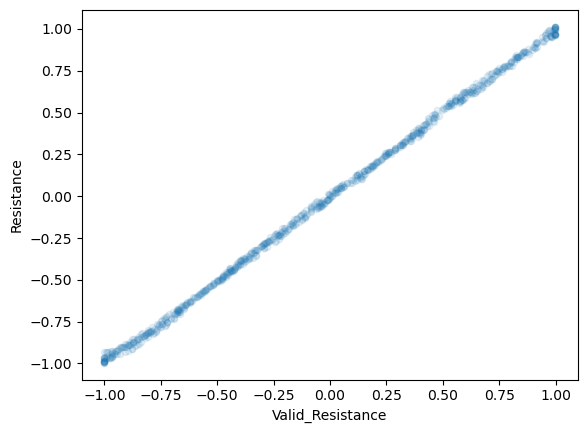

In [53]:
alpa=0.1

ValidPre.plot(kind="scatter", x= "Valid_Resistance",y= "Resistance",alpha = alpa)
plt.savefig('H:/Jupyter_project/wearableActuator/savefig/'+dataname+'.png')
